In [1]:
from tools import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns
from scipy.linalg import fractional_matrix_power
from scipy.stats import wishart
import sys
import time
np.random.seed(121)
def logpdfTarget (x):
    lnp = -(1/2) * (x.T).dot(x)
    return(lnp)

In [2]:
d = 100
Sigma_minus1 = wishart.rvs(df=d,scale=np.eye(d))
cov = np.linalg.inv(Sigma_minus1)
sum(sum(cov>0.99))/2

1155.0

In [3]:
nround = int(5*10e4)
burnin = int(10e3)
x = np.random.random(d) - 0.5
y = np.zeros(nround*d).reshape(nround,d)
accept = np.zeros(d)
mu_star = 0
kernel = 'MirrorU'
time_begin = time.time()
random_result = (np.random.random(size = len(range(-burnin,nround))*d)-0.5) * np.sqrt(12)
sigmaset = np.arange(0.1,2.1,0.1)
target_reuslt = {}

Eff = []; Pjump = []; Exx2=[]; Rho=[]; Sample=[]
for sigma in sigmaset:
    begin_loop = time.time()
    for j in range(-burnin,nround):
        if (j==0):
            count = 0; accept = np.zeros(d);
        for i in range(d):
            initial = x.copy()
            pi_old = logpdfTarget(initial)
            if (kernel == 'Uniform'):
                initial[i] += (np.random.random()-0.5) * np.sqrt(12) * sigma    #Uniform 
            elif (kernel == 'Gaussian'):
                initial[i] += np.random.normal() * sigma                        #Gaussian
            elif (kernel == 'MirrorU'):
                NewCenter = 2 * mu_star - initial[i]
                initial[i] = NewCenter + random_result[(j+burnin)*d+i] * sigma   #Mirror Uniform
            else:
                sys.exit('No such kernel exists')
            pi_new = logpdfTarget(initial)
            pi_dif = pi_new - pi_old
            if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
                x = initial
                accept[i] += 1
        if (j>=0):
            y[j,:] = x

    eff = Eff_IntegratedCorrelationTime(y[:,0])
    exx2 = sum(np.square(y[:,0][1:] - y[:,0][:-1]))
    rho = [rho_k(y[:,0],i) for i in range(1,11)]
    Eff.append(eff)
    Pjump.append(accept[0]/nround)
    Exx2.append(exx2/nround)
    Rho.append(rho)
    Sample.append(y[:,0].copy())
    print ('sigma:',sigma,'|eff:',round(eff,4), '|Pjump:', round(accept[0]/nround,4), '|Exx2:', round(exx2/nround,4),
                   '|rho1:', round(rho[0],4), '|rho2:', round(rho[1],4) ,'|Time:',round((time.time()-begin_loop),2),sep='')
#     print('协方差矩阵: \n',np.cov(np.vstack([y[:,i] for i in range(d)])))
print('总共用时: %f'% (time.time()-time_begin))

sigma:0.1|eff:-6.1044|Pjump:0.9658|Exx2:3.5798|rho1:-0.8712|rho2:0.7619|Time:326.75
sigma:0.2|eff:10.3098|Pjump:0.931|Exx2:3.4678|rho1:-0.7422|rho2:0.5542|Time:321.43
sigma:0.30000000000000004|eff:4.384|Pjump:0.8959|Exx2:3.3214|rho1:-0.6229|rho2:0.3939|Time:339.66
sigma:0.4|eff:3.1127|Pjump:0.8633|Exx2:3.0159|rho1:-0.5186|rho2:0.28|Time:341.56
sigma:0.5|eff:2.4251|Pjump:0.8307|Exx2:2.8503|rho1:-0.4236|rho2:0.1886|Time:335.18
sigma:0.6|eff:1.9776|Pjump:0.798|Exx2:2.6659|rho1:-0.3333|rho2:0.1145|Time:332.6
sigma:0.7000000000000001|eff:1.6699|Pjump:0.7647|Exx2:2.4904|rho1:-0.2489|rho2:0.0644|Time:329.24
sigma:0.8|eff:1.4127|Pjump:0.7336|Exx2:2.3446|rho1:-0.169|rho2:0.0284|Time:334.17
sigma:0.9|eff:1.1985|Pjump:0.703|Exx2:2.1958|rho1:-0.0938|rho2:0.0077|Time:334.13
sigma:1.0|eff:1.0465|Pjump:0.674|Exx2:2.0645|rho1:-0.0296|rho2:0.0006|Time:313.35
sigma:1.1|eff:0.9396|Pjump:0.6462|Exx2:1.9462|rho1:0.0287|rho2:0.0049|Time:314.44
sigma:1.2000000000000002|eff:0.832|Pjump:0.6198|Exx2:1.8322|rho1

In [ ]:
target_result = {}
target_result['100Normal'] = [Eff,Pjump,Exx2,Rho,Sample]
np.save('100Dimensional_target_result',target_result)

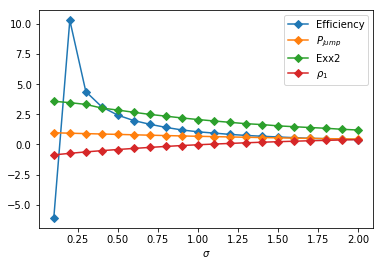

In [39]:
label = ['Efficiency','$P_{jump}$','Exx2']
rho1 = [target_result['100Normal'][3][i][0] for i in range(len(sigmaset))]
[plt.plot(sigmaset,target_result['100Normal'][i],marker='D',label=label[i]) for i in range(3)]
plt.plot(sigmaset,rho1,marker='D',label='$\\rho_1$')
plt.legend()
plt.xlabel('$\sigma$', fontsize=10)
plt.savefig('100Normal_TrueMean.eps', format='eps', dpi=1000)
plt.show()

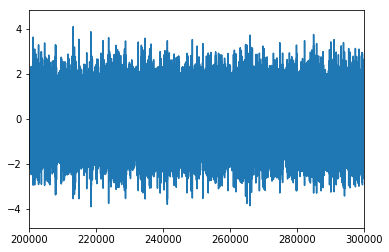

In [57]:
plt.plot(target_result['100Normal'][4][4])
plt.xlim(200000,300000)
plt.savefig('100Normal_TrueMean_TracePlot.eps', format='eps', dpi=1000)
plt.show()